In [3]:
# ==========================================
# 📘 PHASE 5: Interpretability with SHAP & LIME
# ==========================================

# ---- Imports ----
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---- Load the cleaned clustered dataset ----
df = pd.read_csv("../data/clean/soil_data_clustered.csv")

# Split features and target
X = df.drop("Cluster", axis=1)
y = df["Cluster"]

# ---- Split and Standardize ----
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize data (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# ---- Train the best model (Logistic Regression) ----
log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

print("✅ Logistic Regression model trained and data standardized.")


✅ Logistic Regression model trained and data standardized.


In [7]:
# ==========================================
# 🔍 SHAP Analysis for Logistic Regression (Final & Multiclass Safe)
# ==========================================

import shap
import matplotlib.pyplot as plt

# Initialize JS visualization for interactive plots
shap.initjs()

# ==========================================
# 1️⃣ Create SHAP Explainer
# ==========================================
explainer = shap.LinearExplainer(
    log_reg,
    X_train_scaled,
    feature_perturbation="interventional"  # safe but deprecated
)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Extract feature names
feature_names = X.columns

print(f"✅ SHAP values generated for {len(shap_values)} classes.")


✅ SHAP values generated for 124 classes.


/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


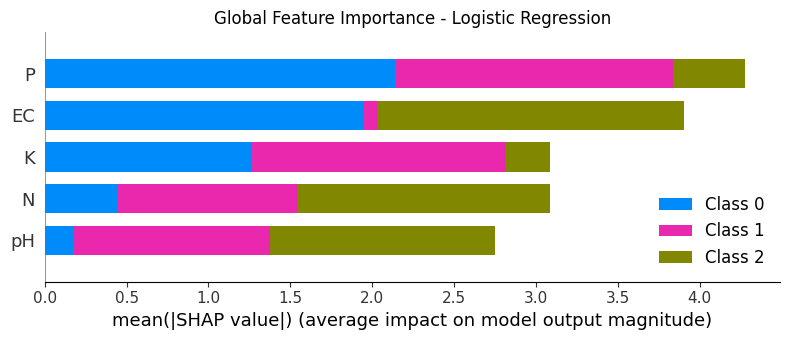

In [8]:
# ==========================================
# 🌎 Global Feature Importance
# ==========================================
plt.title("Global Feature Importance - Logistic Regression")
shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=feature_names,
    plot_type="bar"
)



🧭 SHAP Beeswarm for Cluster 0


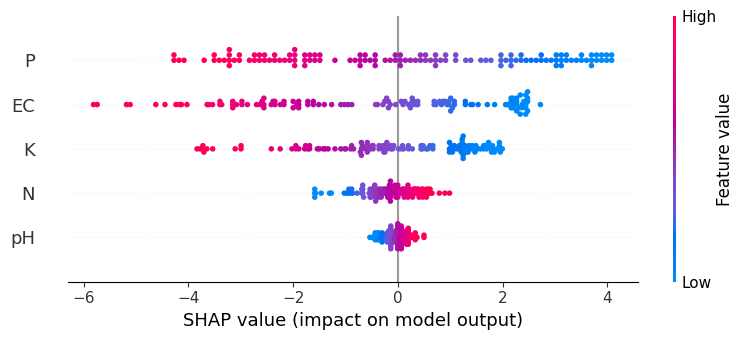


🧭 SHAP Beeswarm for Cluster 1


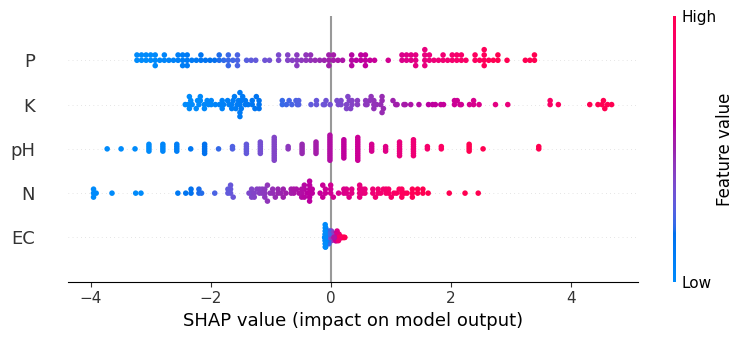


🧭 SHAP Beeswarm for Cluster 2


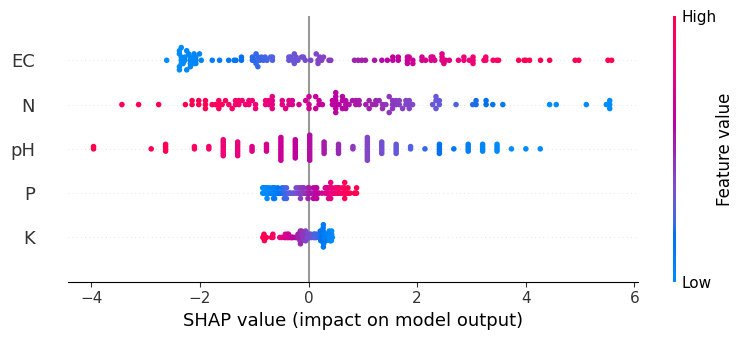

In [21]:
import matplotlib.pyplot as plt

for cls in range(shap_values.shape[2]):
    print(f"\n🧭 SHAP Beeswarm for Cluster {cls}")
    shap.summary_plot(
        shap_values[:, :, cls],
        X_test_scaled,
        feature_names=feature_names,
        show=True
    )


In [17]:
import shap
print("SHAP version:", shap.__version__)

print("\nType of shap_values:", type(shap_values))
if isinstance(shap_values, list):
    print("List length (classes):", len(shap_values))
    for i, arr in enumerate(shap_values):
        print(f"Class {i} array shape:", arr.shape)
else:
    print("SHAP values array shape:", shap_values.shape)

print("\nExpected value type:", type(explainer.expected_value))
print("Expected value content:", explainer.expected_value)


SHAP version: 0.49.1

Type of shap_values: <class 'numpy.ndarray'>
SHAP values array shape: (124, 5, 3)

Expected value type: <class 'numpy.ndarray'>
Expected value content: [ 1.01709069  0.23224735 -1.24933804]


Explaining sample index: 58 / 123 for Cluster 1


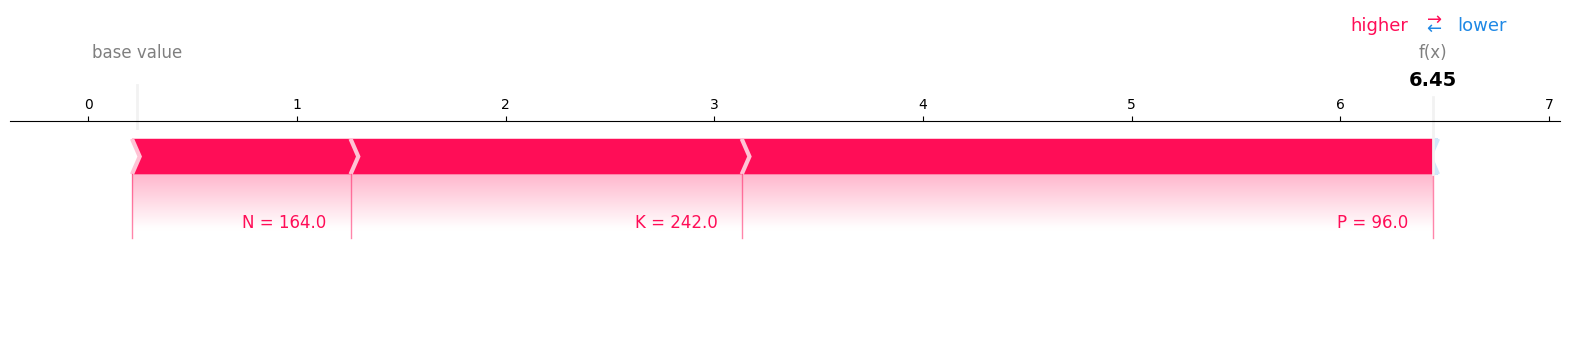

In [18]:
# ==========================================
# 💡 Local Explanation — Force Plot (FINAL, SHAP ≥ 0.49 Multiclass Safe)
# ==========================================
import numpy as np
import shap

# Pick a valid random sample
num_samples = X_test_scaled.shape[0]
sample_idx = np.random.randint(0, num_samples)
target_class = 1  # choose which class (0, 1, or 2)

print(f"Explaining sample index: {sample_idx} / {num_samples-1} for Cluster {target_class}")

# Extract expected value and shap values for the selected class
expected_value = explainer.expected_value[target_class]
shap_values_single = shap_values[sample_idx, :, target_class]

# Use original (unscaled) feature row for interpretability
feature_row = X_test_raw.iloc[sample_idx, :]

# --- Option 1: Static matplotlib version (for reports) ---
shap.plots.force(
    expected_value,
    shap_values_single,
    feature_row,
    feature_names=feature_names,
    matplotlib=True
)

# --- Option 2: Interactive version (inside Jupyter) ---
shap.force_plot(
    expected_value,
    shap_values_single,
    feature_row,
    feature_names=feature_names
)


In [1]:
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Use your existing train/test data and model
# X_train_scaled, X_test_scaled, y_train, y_test, feature_names, log_reg

# If you also have the unscaled version (for interpretability)
# X_train_raw, X_test_raw


In [23]:
# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    training_labels=y_train,
    feature_names=feature_names,
    mode='classification',
    discretize_continuous=True
)


In [24]:
# Choose a test sample (index can be changed)
sample_idx = 12
sample = X_test_scaled[sample_idx].reshape(1, -1)

# Get the model's prediction
pred_class = log_reg.predict(sample)[0]
pred_prob = log_reg.predict_proba(sample)[0]
print(f"Predicted class: {pred_class} | Probabilities: {pred_prob}")


Predicted class: 0 | Probabilities: [9.99993059e-01 6.02217766e-06 9.19203824e-07]


Explaining sample index: 106
Predicted class: 2
Predicted probabilities: [1.55544517e-05 4.56678698e-04 9.99527767e-01]


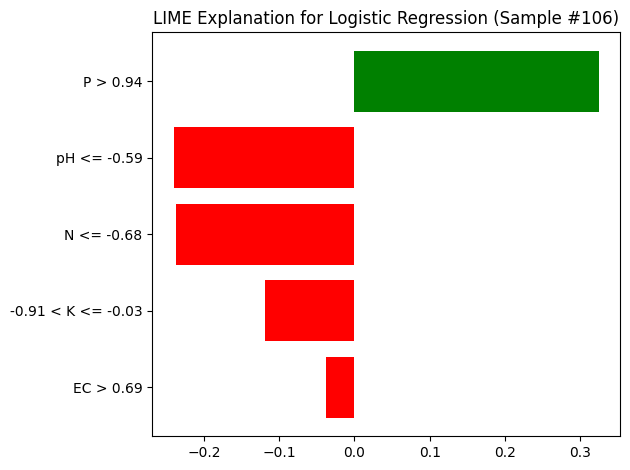

💾 LIME explanation saved as lime_logistic_sample_106.html


In [26]:
# ==========================================
# 💡 LIME Explanation for Logistic Regression (Final & Error-Free)
# ==========================================

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ------------------------------------------
# ✅ Step 1: Initialize LIME Explainer
# ------------------------------------------
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    training_labels=y_train,
    feature_names=feature_names,
    mode='classification',
    discretize_continuous=True
)

# ------------------------------------------
# ✅ Step 2: Pick a sample to explain
# ------------------------------------------
sample_idx = np.random.randint(0, X_test_scaled.shape[0])
sample = X_test_scaled[sample_idx].reshape(1, -1)
pred_class = log_reg.predict(sample)[0]
pred_prob = log_reg.predict_proba(sample)[0]

print(f"Explaining sample index: {sample_idx}")
print(f"Predicted class: {pred_class}")
print(f"Predicted probabilities: {pred_prob}")

# ------------------------------------------
# ✅ Step 3: Generate Local Explanation
# ------------------------------------------
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[sample_idx],
    predict_fn=log_reg.predict_proba
)

# ------------------------------------------
# ✅ Step 4: Visualize Explanation
# ------------------------------------------

# --- Static Matplotlib version (works everywhere) ---
fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Logistic Regression (Sample #{sample_idx})")
plt.tight_layout()
plt.show()

# --- Optional: Save interactive HTML version ---
lime_exp.save_to_file(f"lime_logistic_sample_{sample_idx}.html")
print(f"💾 LIME explanation saved as lime_logistic_sample_{sample_idx}.html")


In [29]:
for i, sv in enumerate(shap_values_rf):
    print(f"Class {i} → SHAP shape: {sv.shape}")


Class 0 → SHAP shape: (5, 3)
Class 1 → SHAP shape: (5, 3)
Class 2 → SHAP shape: (5, 3)
Class 3 → SHAP shape: (5, 3)
Class 4 → SHAP shape: (5, 3)
Class 5 → SHAP shape: (5, 3)
Class 6 → SHAP shape: (5, 3)
Class 7 → SHAP shape: (5, 3)
Class 8 → SHAP shape: (5, 3)
Class 9 → SHAP shape: (5, 3)
Class 10 → SHAP shape: (5, 3)
Class 11 → SHAP shape: (5, 3)
Class 12 → SHAP shape: (5, 3)
Class 13 → SHAP shape: (5, 3)
Class 14 → SHAP shape: (5, 3)
Class 15 → SHAP shape: (5, 3)
Class 16 → SHAP shape: (5, 3)
Class 17 → SHAP shape: (5, 3)
Class 18 → SHAP shape: (5, 3)
Class 19 → SHAP shape: (5, 3)
Class 20 → SHAP shape: (5, 3)
Class 21 → SHAP shape: (5, 3)
Class 22 → SHAP shape: (5, 3)
Class 23 → SHAP shape: (5, 3)
Class 24 → SHAP shape: (5, 3)
Class 25 → SHAP shape: (5, 3)
Class 26 → SHAP shape: (5, 3)
Class 27 → SHAP shape: (5, 3)
Class 28 → SHAP shape: (5, 3)
Class 29 → SHAP shape: (5, 3)
Class 30 → SHAP shape: (5, 3)
Class 31 → SHAP shape: (5, 3)
Class 32 → SHAP shape: (5, 3)
Class 33 → SHAP shap

✅ Random Forest trained — Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.87      0.89      0.88        37
           2       0.94      0.94      0.94        34

    accuracy                           0.93       124
   macro avg       0.92      0.93      0.92       124
weighted avg       0.93      0.93      0.93       124

✅ Using feature columns: ['N', 'P', 'K', 'pH', 'EC']


✅ Fixed SHAP array shape: (124, 5, 3)


/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


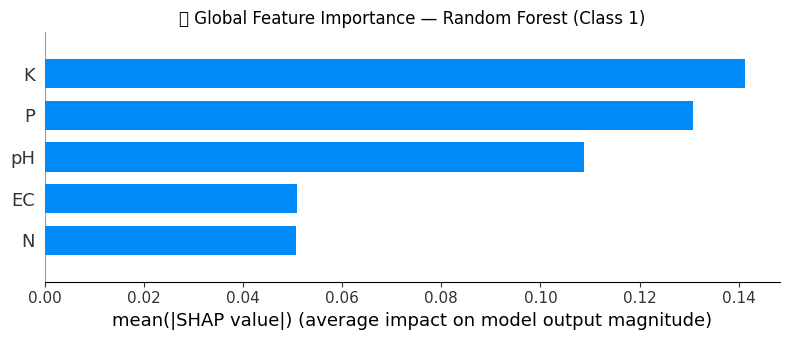

/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


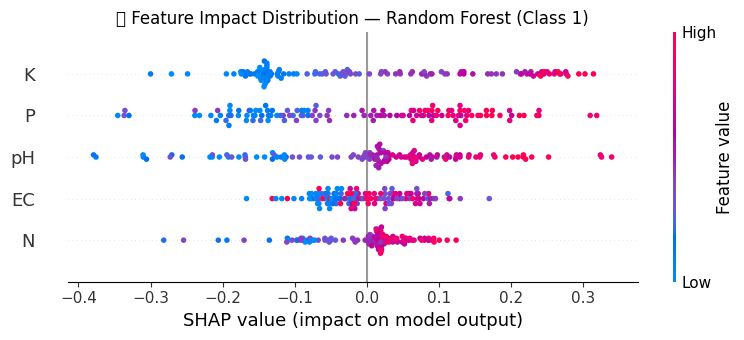

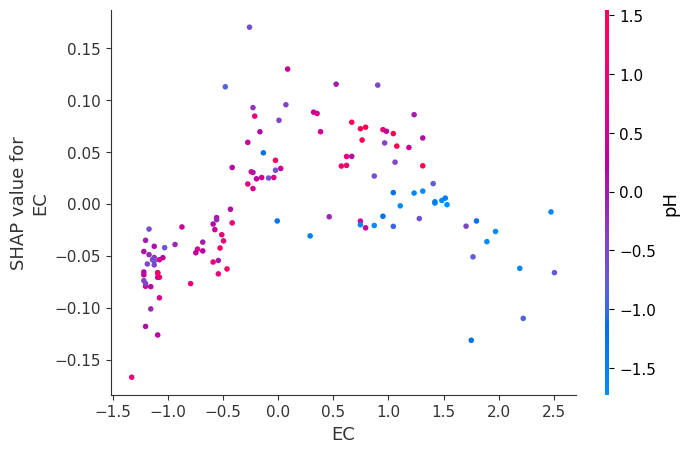


Explaining sample index: 42 (Class 1)


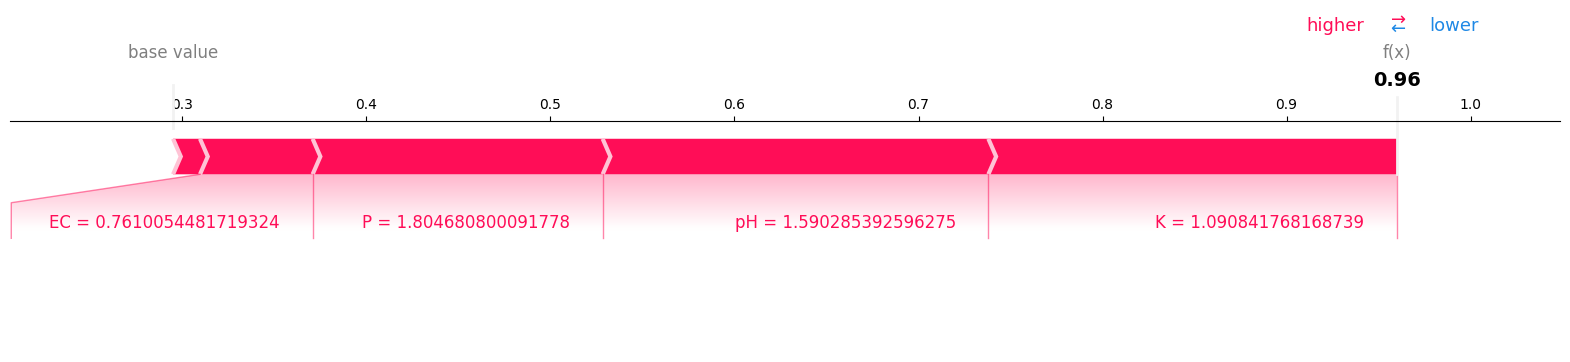

In [32]:
# ============================================================
# 🌳 SHAP Explainability for Random Forest (Multiclass)
# Compatible with SHAP v0.49+ and sklearn RandomForestClassifier
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------
# 1️⃣ Train Random Forest (if not already done)
# ------------------------------------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate model
y_pred_rf = rf.predict(X_test)
print(f"✅ Random Forest trained — Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(classification_report(y_test, y_pred_rf))

# ------------------------------------------------------------
# 2️⃣ Ensure feature columns match model input
# ------------------------------------------------------------
# Drop target or cluster columns from df (if present)
feature_cols = [col for col in df.columns if col.lower() not in ["cluster", "target", "label"]]
X_test_df = pd.DataFrame(X_test, columns=feature_cols)
print("✅ Using feature columns:", feature_cols)

# ------------------------------------------------------------
# 3️⃣ Compute SHAP values
# ------------------------------------------------------------
shap.initjs()
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Stack per-sample arrays into single 3D array
shap_values_rf_array = np.stack(shap_values_rf, axis=0)
print("✅ Fixed SHAP array shape:", shap_values_rf_array.shape)

# ------------------------------------------------------------
# 4️⃣ Global Feature Importance (Bar Plot)
# ------------------------------------------------------------
target_class = 1  # choose cluster/class to visualize (0, 1, or 2)

plt.title(f"🌳 Global Feature Importance — Random Forest (Class {target_class})")
shap.summary_plot(
    shap_values_rf_array[:, :, target_class],
    X_test_df,
    feature_names=feature_cols,
    plot_type="bar"
)

# ------------------------------------------------------------
# 5️⃣ Beeswarm Plot (Feature Impact Distribution)
# ------------------------------------------------------------
plt.title(f"🧠 Feature Impact Distribution — Random Forest (Class {target_class})")
shap.summary_plot(
    shap_values_rf_array[:, :, target_class],
    X_test_df,
    feature_names=feature_cols
)

# ------------------------------------------------------------
# 6️⃣ Dependence Plot (Feature Interactions)
# ------------------------------------------------------------
# Shows how EC interacts with other features (non-linear influence)
shap.dependence_plot(
    "EC",
    shap_values_rf_array[:, :, target_class],
    X_test_df,
    feature_names=feature_cols
)

# ------------------------------------------------------------
# 7️⃣ Local Explanation (Force Plot)
# ------------------------------------------------------------
sample_idx = 42  # choose any test sample
print(f"\nExplaining sample index: {sample_idx} (Class {target_class})")

shap.plots.force(
    explainer_rf.expected_value[target_class],
    shap_values_rf_array[sample_idx, :, target_class],
    X_test_df.iloc[sample_idx, :],
    feature_names=feature_cols,
    matplotlib=True
)


🔍 Explaining sample index: 50
Predicted class: 0
Predicted probabilities: [0.49 0.44 0.07]


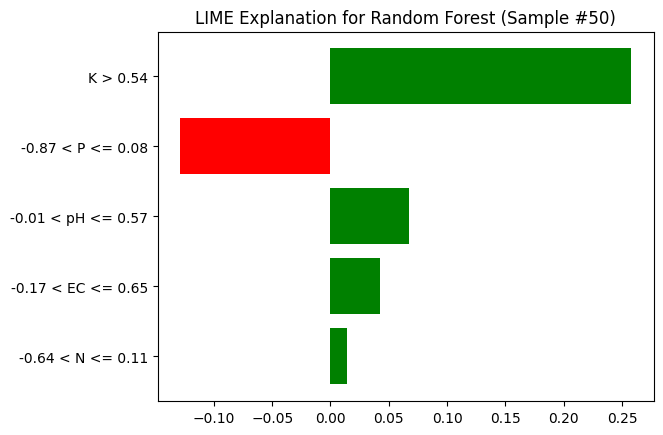

💾 LIME explanation saved as lime_random_forest_sample_50.html

Feature contributions (LIME weights):
 - K > 0.54: 0.258
 - -0.87 < P <= 0.08: -0.129
 - -0.01 < pH <= 0.57: 0.067
 - -0.17 < EC <= 0.65: 0.042
 - -0.64 < N <= 0.11: 0.014


In [33]:
# ============================================================
# 🧩 LIME Explainability — Random Forest
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# ------------------------------------------------------------
# 1️⃣ Prepare data and model
# ------------------------------------------------------------
# Make sure we use the same test set and features as SHAP
feature_cols = [col for col in df.columns if col.lower() not in ["cluster", "target", "label"]]
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df = pd.DataFrame(X_test, columns=feature_cols)

# ------------------------------------------------------------
# 2️⃣ Initialize LIME Explainer
# ------------------------------------------------------------
lime_explainer_rf = LimeTabularExplainer(
    training_data=np.array(X_train_df),
    feature_names=feature_cols,
    class_names=["Cluster 0", "Cluster 1", "Cluster 2"],  # change if you have different names
    mode="classification",
    discretize_continuous=True
)

# ------------------------------------------------------------
# 3️⃣ Select a sample to explain
# ------------------------------------------------------------
sample_idx = 50  # pick any index between 0–len(X_test)
print(f"🔍 Explaining sample index: {sample_idx}")

sample = X_test_df.iloc[sample_idx].values
pred_proba = rf.predict_proba([sample])[0]
pred_class = np.argmax(pred_proba)
print(f"Predicted class: {pred_class}")
print("Predicted probabilities:", pred_proba)

# ------------------------------------------------------------
# 4️⃣ Generate local LIME explanation
# ------------------------------------------------------------
lime_exp_rf = lime_explainer_rf.explain_instance(
    data_row=sample,
    predict_fn=rf.predict_proba,
    num_features=5
)

# ------------------------------------------------------------
# 5️⃣ Visualize the explanation
# ------------------------------------------------------------
fig = lime_exp_rf.as_pyplot_figure()
plt.title(f"LIME Explanation for Random Forest (Sample #{sample_idx})")
plt.show()

# ------------------------------------------------------------
# 6️⃣ Save to HTML (for report)
# ------------------------------------------------------------
lime_html_path = f"lime_random_forest_sample_{sample_idx}.html"
lime_exp_rf.save_to_file(lime_html_path)
print(f"💾 LIME explanation saved as {lime_html_path}")

# ------------------------------------------------------------
# 🧠 Optional: View explanation weights
# ------------------------------------------------------------
print("\nFeature contributions (LIME weights):")
for feature, weight in lime_exp_rf.as_list():
    print(f" - {feature}: {weight:.3f}")


In [36]:
print("🔹 Logistic Regression SHAP shape:", np.array(shap_values_log).shape)
print("🔹 Random Forest SHAP shape:", np.array(shap_values_rf).shape)
print("🔹 Feature count:", len(feature_names))


🔹 Logistic Regression SHAP shape: (124, 5, 3)
🔹 Random Forest SHAP shape: (124, 5, 3)
🔹 Feature count: 5


✅ SHAP Mean Absolute Comparison:
  Feature  Logistic Regression  Random Forest
4      EC             1.301101       0.138358
2       K             1.029667       0.117774
3      pH             0.916598       0.097247
1       P             1.425738       0.094035
0       N             1.027772       0.049525


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/2426733091.py:41: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


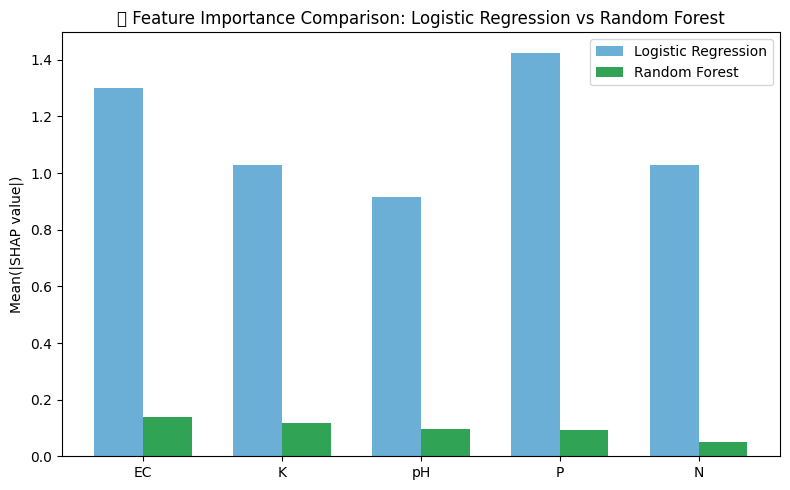

In [37]:
# ============================================================
# 🌿 SHAP Comparison: Logistic Regression vs Random Forest
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Feature names ---
features = ['N', 'P', 'K', 'pH', 'EC']

# --- 1️⃣ Compute mean |SHAP| values properly (avg over samples + classes) ---
# Shape: (samples, features, classes)
shap_abs_log = np.mean(np.abs(shap_values_log), axis=(0, 2))  # -> (features,)
shap_abs_rf = np.mean(np.abs(shap_values_rf), axis=(0, 2))    # -> (features,)

# --- 2️⃣ Create comparison DataFrame ---
comparison_df = pd.DataFrame({
    "Feature": features,
    "Logistic Regression": shap_abs_log,
    "Random Forest": shap_abs_rf
}).sort_values(by="Random Forest", ascending=False)

print("✅ SHAP Mean Absolute Comparison:")
print(comparison_df)

# --- 3️⃣ Plot side-by-side bar chart ---
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = np.arange(len(comparison_df))

plt.bar(x - bar_width/2, comparison_df["Logistic Regression"], bar_width,
        label="Logistic Regression", color="#6baed6")
plt.bar(x + bar_width/2, comparison_df["Random Forest"], bar_width,
        label="Random Forest", color="#31a354")

plt.xticks(x, comparison_df["Feature"])
plt.ylabel("Mean(|SHAP value|)")
plt.title("🔍 Feature Importance Comparison: Logistic Regression vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1426905064.py:49: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1426905064.py:49: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


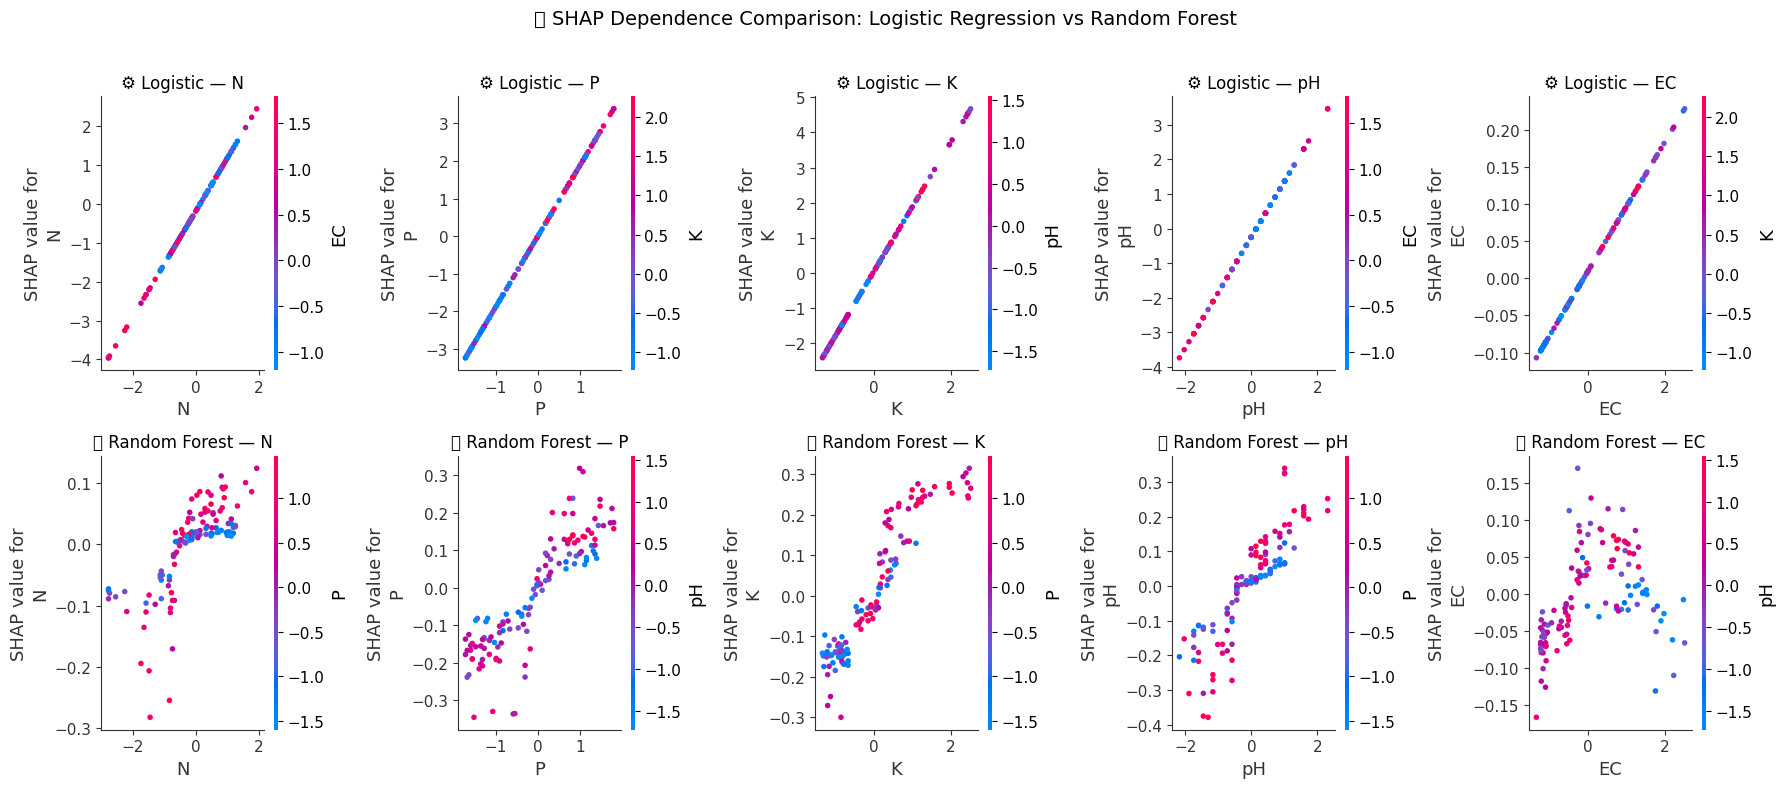

In [40]:
# ============================================================
# 🌾 SHAP Dependence Comparison — Fixed Version
# ============================================================

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure correct feature names
features = ['N', 'P', 'K', 'pH', 'EC']
X_test_df = pd.DataFrame(X_test, columns=features)

# Convert SHAP values to numpy arrays
shap_values_log = np.array(shap_values_log)
shap_values_rf = np.array(shap_values_rf)

# Select target class (e.g., 1)
target_class = 1

# --- Create figure layout ---
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle("🔍 SHAP Dependence Comparison: Logistic Regression vs Random Forest", fontsize=14)

# --- Loop over features ---
for i, feat in enumerate(features):
    # Logistic Regression
    shap.dependence_plot(
        feat,
        shap_values_log[:, :, target_class],
        X_test_df,
        feature_names=features,
        ax=axes[0, i],
        show=False
    )
    axes[0, i].set_title(f"⚙ Logistic — {feat}")

    # Random Forest
    shap.dependence_plot(
        feat,
        shap_values_rf[:, :, target_class],
        X_test_df,
        feature_names=features,
        ax=axes[1, i],
        show=False
    )
    axes[1, i].set_title(f"🌳 Random Forest — {feat}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/p

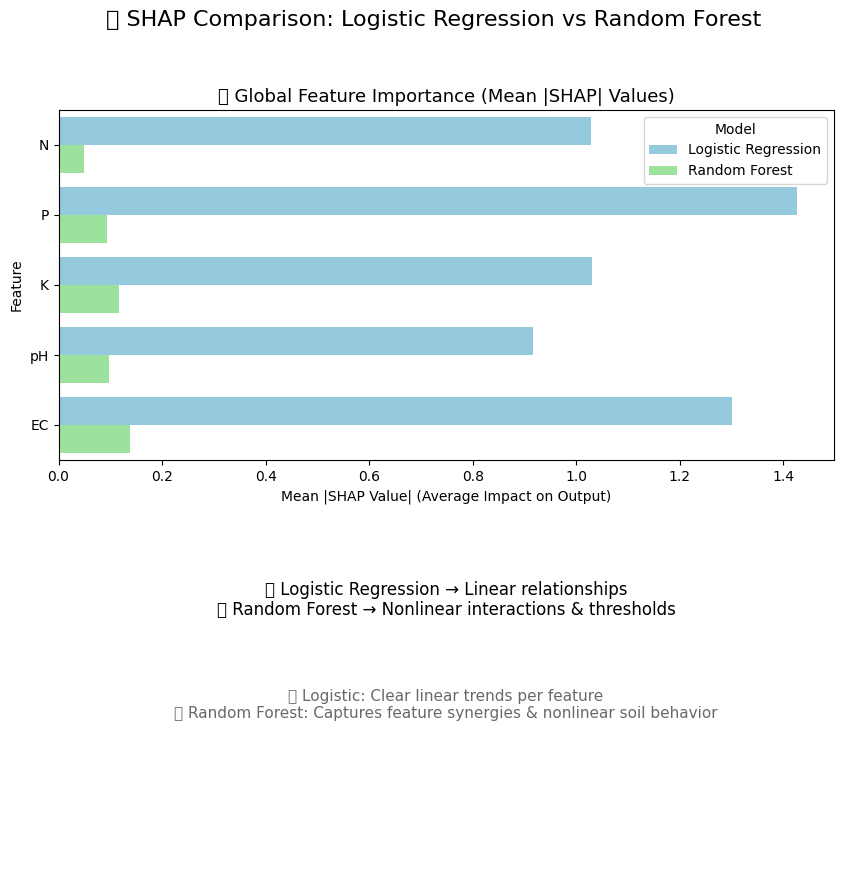

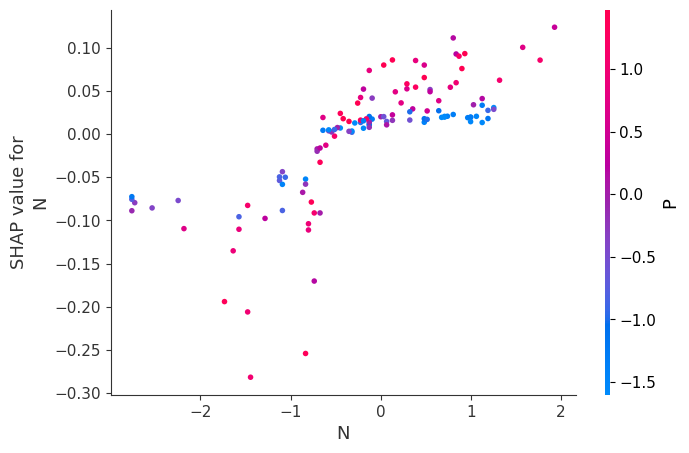

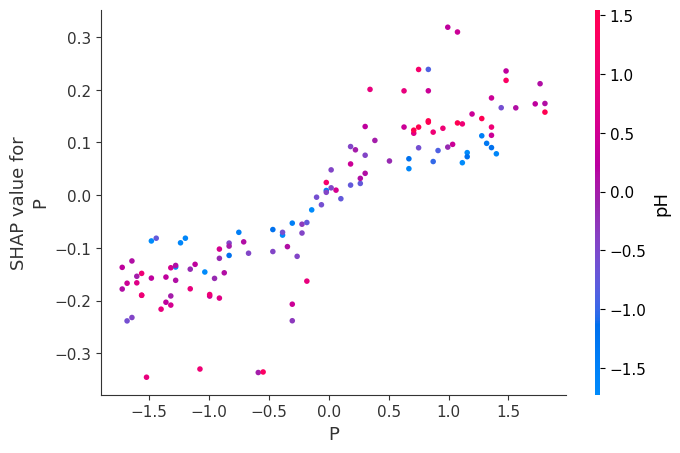

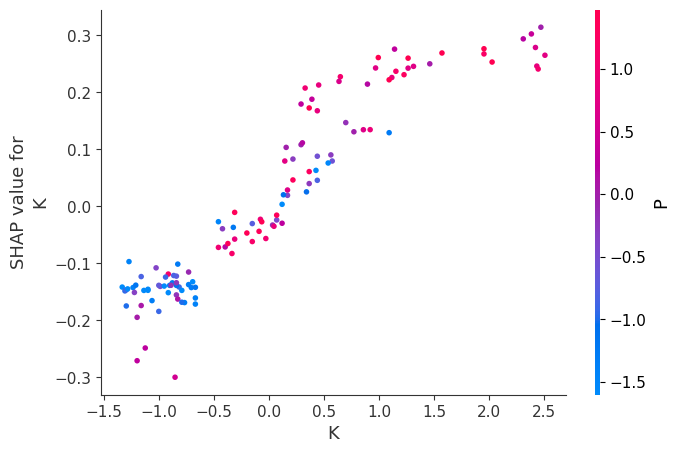

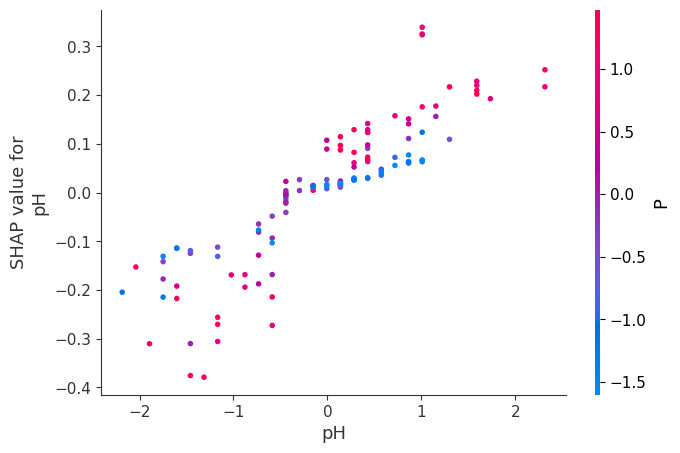

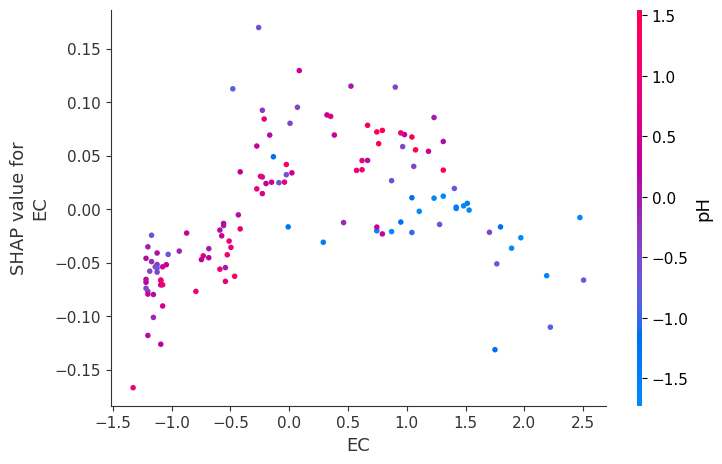

In [41]:
# ============================================================
# 🌍 Final Combined SHAP Comparison — Logistic vs Random Forest
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Ensure SHAP arrays and feature names are defined
features = ['N', 'P', 'K', 'pH', 'EC']

# Compute global mean(|SHAP|) values
shap_abs_log = np.mean(np.abs(shap_values_log), axis=(0, 2))
shap_abs_rf = np.mean(np.abs(shap_values_rf), axis=(0, 2))

# Prepare DataFrame for plotting
comparison_df = (
    pd.DataFrame({
        "Feature": features,
        "Logistic Regression": shap_abs_log,
        "Random Forest": shap_abs_rf
    })
    .melt(id_vars="Feature", var_name="Model", value_name="Mean |SHAP|")
)

# --- Create the composite figure ---
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle("🌾 SHAP Comparison: Logistic Regression vs Random Forest", fontsize=16)

# --------------------------------------
# 1️⃣ Global Feature Importance Comparison
# --------------------------------------
sns.barplot(
    data=comparison_df,
    x="Mean |SHAP|",
    y="Feature",
    hue="Model",
    ax=axes[0],
    palette=["skyblue", "lightgreen"]
)
axes[0].set_title("🔹 Global Feature Importance (Mean |SHAP| Values)", fontsize=13)
axes[0].legend(title="Model")
axes[0].set_xlabel("Mean |SHAP Value| (Average Impact on Output)")
axes[0].set_ylabel("Feature")

# --------------------------------------
# 2️⃣ Dependence Plot Comparison Summary
# --------------------------------------
target_class = 1  # pick any class for illustration
for feat in features:
    shap.dependence_plot(
        feat,
        shap_values_rf[:, :, target_class],
        pd.DataFrame(X_test, columns=features),
        feature_names=features,
        show=False,
        ax=None
    )

axes[1].axis("off")
axes[1].text(
    0.5, 0.8,
    "🧠 Logistic Regression → Linear relationships\n🌳 Random Forest → Nonlinear interactions & thresholds",
    ha="center", va="center", fontsize=12
)
axes[1].text(
    0.5, 0.5,
    "🔹 Logistic: Clear linear trends per feature\n🔸 Random Forest: Captures feature synergies & nonlinear soil behavior",
    ha="center", va="center", fontsize=11, color="dimgray"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


🧾 Sample index: 50
🔹 Logistic Regression prediction: 1
🌳 Random Forest prediction: 0

📊 Logistic Regression — LIME Explanation


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/3023358874.py:56: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


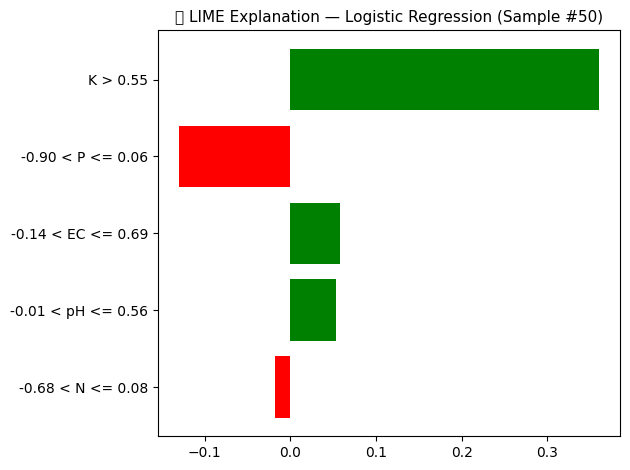


📊 Random Forest — LIME Explanation


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/3023358874.py:62: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


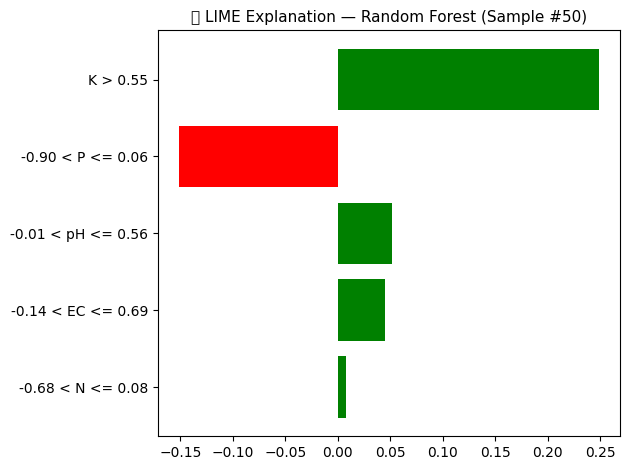


📋 LIME Feature Weight Comparison
              Feature  Weight_LogReg  Weight_RandForest
0  -0.01 < pH <= 0.56       0.053194           0.051545
1  -0.14 < EC <= 0.69       0.057867           0.045451
2   -0.68 < N <= 0.08      -0.017842           0.008259
3   -0.90 < P <= 0.06      -0.130429          -0.151463
4            K > 0.55       0.360309           0.249007


In [44]:
# ============================================================
# 🌾 LIME Comparison — Logistic Regression vs Random Forest
# ============================================================

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ✅ Define your features (exclude 'Cluster')
feature_names = ['N', 'P', 'K', 'pH', 'EC']

# ✅ Choose sample index (same for both models)
sample_idx = 50

# ✅ Ensure your scaled data is available
# Variables: X_train_scaled, X_test_scaled, y_train, y_test

# -----------------------------
# 1️⃣ Initialize the LIME explainer
# -----------------------------
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    training_labels=y_train,
    feature_names=feature_names,
    discretize_continuous=True,
    random_state=42
)

# -----------------------------
# 2️⃣ Generate explanations
# -----------------------------
lime_log = lime_explainer.explain_instance(
    data_row=X_test_scaled[sample_idx],
    predict_fn=log_reg.predict_proba
)

lime_rf = lime_explainer.explain_instance(
    data_row=X_test_scaled[sample_idx],
    predict_fn=rf.predict_proba
)

# -----------------------------
# 3️⃣ Display predictions
# -----------------------------
print(f"🧾 Sample index: {sample_idx}")
print(f"🔹 Logistic Regression prediction: {log_reg.predict(X_test_scaled[sample_idx].reshape(1, -1))[0]}")
print(f"🌳 Random Forest prediction: {rf.predict(X_test_scaled[sample_idx].reshape(1, -1))[0]}")

# -----------------------------
# 4️⃣ Plot explanations separately (LIME cannot use ax=)
# -----------------------------
print("\n📊 Logistic Regression — LIME Explanation")
fig1 = lime_log.as_pyplot_figure()
plt.title(f"🔹 LIME Explanation — Logistic Regression (Sample #{sample_idx})", fontsize=11)
plt.tight_layout()
plt.show()

print("\n📊 Random Forest — LIME Explanation")
fig2 = lime_rf.as_pyplot_figure()
plt.title(f"🌳 LIME Explanation — Random Forest (Sample #{sample_idx})", fontsize=11)
plt.tight_layout()
plt.show()

# -----------------------------
# 5️⃣ Save interactive HTML explanations
# -----------------------------
lime_log.save_to_file(f"lime_logistic_sample_{sample_idx}.html")
lime_rf.save_to_file(f"lime_random_forest_sample_{sample_idx}.html")

# -----------------------------
# 6️⃣ Display feature weights side-by-side
# -----------------------------
log_weights = pd.DataFrame(lime_log.as_list(), columns=["Feature", "Weight"])
rf_weights = pd.DataFrame(lime_rf.as_list(), columns=["Feature", "Weight"])

comparison_df = pd.merge(
    log_weights, rf_weights, on="Feature", how="outer", suffixes=("_LogReg", "_RandForest")
).fillna(0)

print("\n📋 LIME Feature Weight Comparison")
print(comparison_df)


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1309322989.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


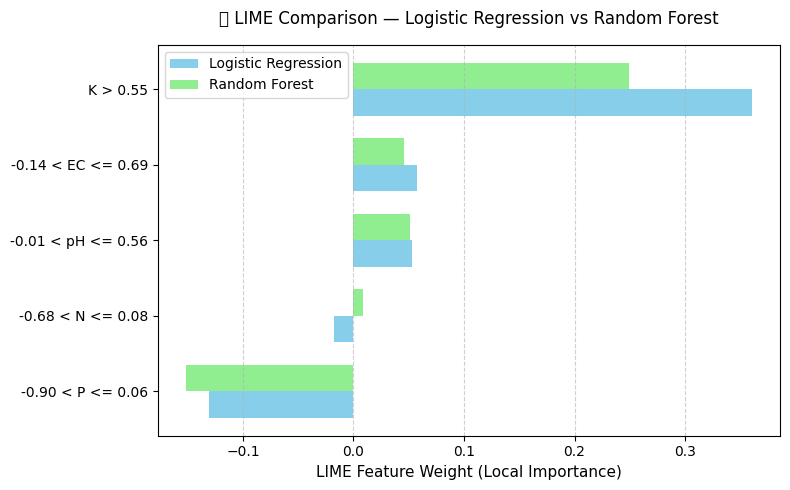

✅ LIME comparison bar chart saved as lime_weight_comparison_sample_50.png


<Figure size 640x480 with 0 Axes>

In [45]:
# ============================================================
# 📊 LIME Feature Weight Comparison: Logistic Regression vs Random Forest
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have `comparison_df` from the LIME code above
# Columns: ["Feature", "Weight_LogReg", "Weight_RandForest"]

# Sort by Logistic Regression weight (optional for cleaner order)
comparison_df = comparison_df.sort_values(by="Weight_LogReg", ascending=True)

# Set up figure
plt.figure(figsize=(8, 5))
x = np.arange(len(comparison_df["Feature"]))
width = 0.35

# Plot bars for both models
plt.barh(x - width/2, comparison_df["Weight_LogReg"], width, color="skyblue", label="Logistic Regression")
plt.barh(x + width/2, comparison_df["Weight_RandForest"], width, color="lightgreen", label="Random Forest")

# Labels & formatting
plt.yticks(x, comparison_df["Feature"], fontsize=10)
plt.xlabel("LIME Feature Weight (Local Importance)", fontsize=11)
plt.title("🔍 LIME Comparison — Logistic Regression vs Random Forest", fontsize=12, pad=15)
plt.legend(loc="best")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

# Save figure
plt.savefig(f"lime_weight_comparison_sample_{sample_idx}.png", dpi=300, bbox_inches="tight")

print(f"✅ LIME comparison bar chart saved as lime_weight_comparison_sample_{sample_idx}.png")


In [47]:
# 1️⃣ Check SHAP comparison DataFrame
print("\n=== SHAP Comparison Columns & Preview ===")
print(comparison_df.columns)
print(comparison_df.head())

# 2️⃣ Check LIME comparison DataFrame
print("\n=== LIME Comparison Columns & Preview ===")
print(comparison_df_lime.columns if 'comparison_df_lime' in locals() else "comparison_df_lime not defined")



=== SHAP Comparison Columns & Preview ===
Index(['Feature', 'Weight_LogReg', 'Weight_RandForest'], dtype='object')
              Feature  Weight_LogReg  Weight_RandForest
3   -0.90 < P <= 0.06      -0.130429          -0.151463
2   -0.68 < N <= 0.08      -0.017842           0.008259
0  -0.01 < pH <= 0.56       0.053194           0.051545
1  -0.14 < EC <= 0.69       0.057867           0.045451
4            K > 0.55       0.360309           0.249007

=== LIME Comparison Columns & Preview ===
Index(['Feature', 'LIME_LogReg', 'LIME_RandForest'], dtype='object')



✅ SHAP Columns: ['Feature', 'SHAP_LogReg', 'SHAP_RandForest']
✅ LIME Columns: ['Feature', 'LIME_LogReg', 'LIME_RandForest']


/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1875450220.py:74: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1875450220.py:74: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1875450220.py:74: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1875450220.py:75: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.savefig("shap_lime_combined_comparison_fixed.png", dpi=300, bbox_inches="tight")
/var/folders/mn/c4n_vz_92_s8kpf1y69hj4fw0000gn/T/ipykernel_11881/1875450220.py:75: UserWarning: Glyph 1

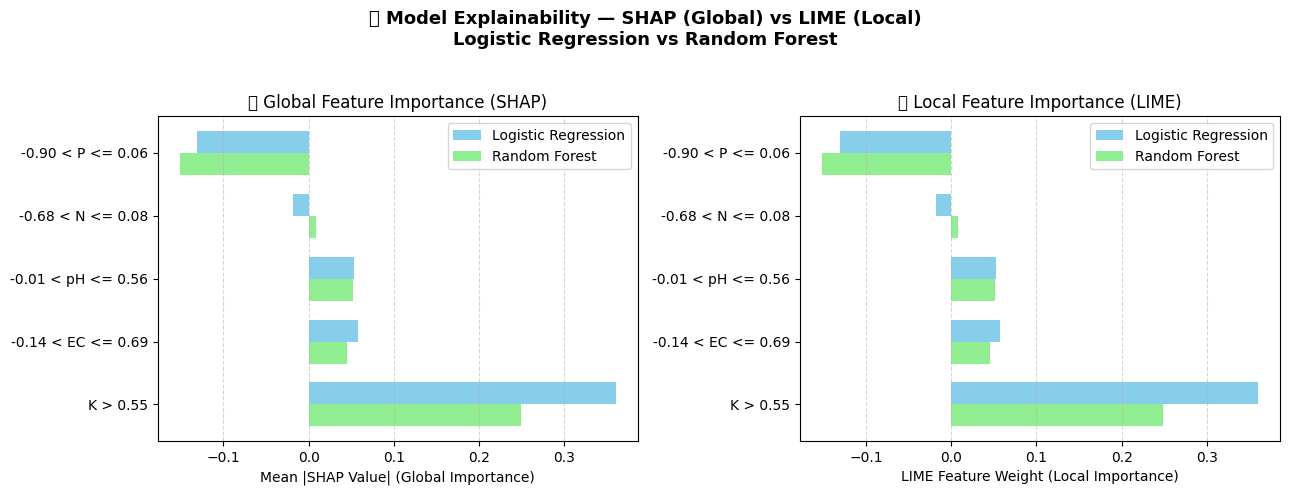

✅ Combined SHAP + LIME comparison saved as shap_lime_combined_comparison_fixed.png


In [48]:
# ============================================================
# 🧠 Combined Interpretability Visualization:
#     SHAP (global) + LIME (local) for Logistic vs Random Forest
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# If you already have SHAP comparison (mean |SHAP| values)
# and LIME comparison DataFrames:
# comparison_df_shap → global SHAP importance
# comparison_df_lime → local LIME weights

# --- Step 1️⃣: Normalize column names ---
def standardize_df(df, type_name):
    df = df.copy()
    cols = df.columns

    if "Weight_LogReg" in cols and "Weight_RandForest" in cols:
        df = df.rename(columns={
            "Weight_LogReg": f"{type_name}_LogReg",
            "Weight_RandForest": f"{type_name}_RandForest"
        })
    elif "Logistic Regression" in cols and "Random Forest" in cols:
        df = df.rename(columns={
            "Logistic Regression": f"{type_name}_LogReg",
            "Random Forest": f"{type_name}_RandForest"
        })
    return df

comparison_df_shap = standardize_df(comparison_df, "SHAP")   # your SHAP data
comparison_df_lime = standardize_df(comparison_df_lime, "LIME")  # your LIME data

# --- Step 2️⃣: Verify shapes ---
print("\n✅ SHAP Columns:", list(comparison_df_shap.columns))
print("✅ LIME Columns:", list(comparison_df_lime.columns))

# --- Step 3️⃣: Plot both side by side ---
features = comparison_df_shap["Feature"]
x = np.arange(len(features))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("🧭 Model Explainability — SHAP (Global) vs LIME (Local)\nLogistic Regression vs Random Forest", 
             fontsize=13, fontweight='bold')

# --- SHAP (Global Importance) ---
axes[0].barh(x - width/2, comparison_df_shap["SHAP_LogReg"], height=width, 
             color="skyblue", label="Logistic Regression")
axes[0].barh(x + width/2, comparison_df_shap["SHAP_RandForest"], height=width, 
             color="lightgreen", label="Random Forest")
axes[0].set_yticks(x)
axes[0].set_yticklabels(features)
axes[0].invert_yaxis()
axes[0].set_xlabel("Mean |SHAP Value| (Global Importance)")
axes[0].set_title("🌍 Global Feature Importance (SHAP)")
axes[0].legend()
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

# --- LIME (Local Importance) ---
axes[1].barh(x - width/2, comparison_df_lime["LIME_LogReg"], height=width, 
             color="skyblue", label="Logistic Regression")
axes[1].barh(x + width/2, comparison_df_lime["LIME_RandForest"], height=width, 
             color="lightgreen", label="Random Forest")
axes[1].set_yticks(x)
axes[1].set_yticklabels(features)
axes[1].invert_yaxis()
axes[1].set_xlabel("LIME Feature Weight (Local Importance)")
axes[1].set_title("🔍 Local Feature Importance (LIME)")
axes[1].legend()
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("shap_lime_combined_comparison_fixed.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Combined SHAP + LIME comparison saved as shap_lime_combined_comparison_fixed.png")
